In [3]:
!python -V

Python 3.10.4


In [4]:
import os
import pickle
import pandas as pd

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error


## Download the data

In [24]:
import os
# https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet
tripdata_filenames = ["fhv_tripdata_2021-01.parquet", "fhv_tripdata_2021-02.parquet"]
tripdata_filename_jan = tripdata_filenames[0]
tripdata_filename_feb = tripdata_filenames[1]

In [23]:
!mkdir data
for trip_filename in tripdata_filenames:
    if not os.path.exists(f'data/{trip_filename}'):
        print(f'Downloading {trip_filename}')
        full_url = f'https://nyc-tlc.s3.amazonaws.com/trip+data/{trip_filename}'
        !wget -P data $full_url
    else:
        print(f'File {trip_filename} already exists!')

mkdir: cannot create directory ‘data’: File exists
File fhv_tripdata_2021-01.parquet already exists!
File fhv_tripdata_2021-02.parquet already exists!


In [111]:
def create_target(df):
    df = df.copy()
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df['duration'] = df.duration.dt.total_seconds() / 60
    return df

In [110]:
df_jan = pd.read_parquet(f'data/{tripdata_filename_jan}')

In [112]:
df_jan = create_target(df_jan)
df_jan.head(3)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.0
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.0
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013,110.0


## 1. Read the data for January.
How many records are there?

In [113]:
print(f'There are {df_jan.shape[0]} records in january dataframe.')

There are 1154112 records in january dataframe.


In [114]:
df_jan['duration'] = df_jan.dropOff_datetime - df_jan.pickup_datetime
df_jan.duration = df_jan.duration.dt.total_seconds() / 60 

## 2 
Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the average trip duration in January?

In [116]:
df_jan.duration.mean()

19.167224093791006

Filter the data, remove outliers - the trips with duration under 1 minute and over 60 minutes

In [117]:
df_jan = df[(df.duration >= 1) & (df_jan.duration <= 60)].copy()
df_jan.count()

/tmp/ipykernel_30136/3220815837.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_jan = df[(df.duration >= 1) & (df_jan.duration <= 60)].copy()


dispatching_base_num      1109826
pickup_datetime           1109826
dropOff_datetime          1109826
PUlocationID              1109826
DOlocationID              1109826
SR_Flag                         0
Affiliated_base_number    1109053
duration                  1109826
dtype: int64

## 3 .  Missing values
The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

In [118]:
df_jan['PUlocationID'] = df_jan['PUlocationID'].fillna(-1)
df_jan['DOlocationID'] = df_jan['DOlocationID'].fillna(-1)
#df[(df.PUlocationID.isna())]

In [119]:
df_jan['PUlocationID'].value_counts(sort=True)[0]

927008

In [120]:
#df[df.PUlocationID == -1].count()
empty_minus_1_count = df_jan['PUlocationID'].value_counts(sort=True)[0]
print(empty_minus_1_count)
all_count = df_jan['PUlocationID'].shape[0]
print(all_count)
percent_with_missing_values = empty_minus_1_count / all_count
percent_with_missing_values

927008
1109826


0.8352732770722617

In [121]:
print(f'Percent with missing PUlocationID values: {percent_with_missing_values}')

Percent with missing PUlocationID values: 0.8352732770722617


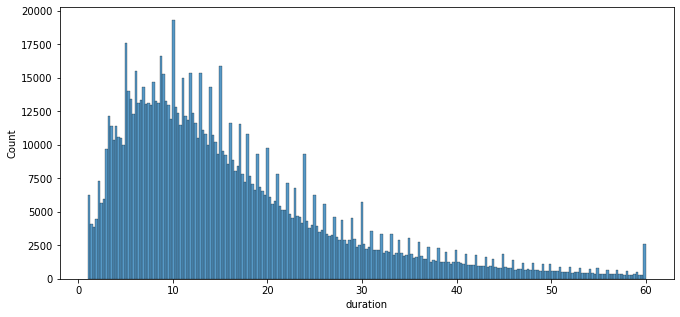

In [96]:
fig = plt.figure(figsize=(11,5))
sns.histplot(df_jan.duration);

## 4. One-hot encoding

In [123]:
categorical = ['PUlocationID', 'DOlocationID']

df_jan[categorical] = df_jan[categorical].astype(str)


train_dicts = df_jan[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [124]:
X_train.shape

(1109826, 525)

In [125]:
f'Number of columns of the matrix : {X_train.shape[1]}'

'Number of columns of the matrix : 525'

## 5. Training the model

In [127]:
target = 'duration'
y_train = df_jan[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)
# Predict: 
y_pred = lr.predict(X_train)

mse = mean_squared_error(y_train, y_pred, squared=False)
print(f'MSE: {mse}')

MSE: 10.528519395264997


## 6. Evaluating the model

In [126]:
df_feb = pd.read_parquet(f'data/{tripdata_filename_feb}')

df_feb = create_target(df_feb)

# filter out the outliers
df_feb = df_feb[(df_feb.duration >= 1) & (df_feb.duration <= 60)].copy()

df_feb['PUlocationID'] = df_feb['PUlocationID'].fillna(-1)

categorical = ['PUlocationID', 'DOlocationID']

df_feb[categorical] = df_feb[categorical].astype(str)

val_dicts = df_feb[categorical].to_dict(orient='records')

X_val = dv.transform(val_dicts)


In [129]:
y_val = df_feb[target].values
y_pred_val = lr.predict(X_val)
# Calculate rmse between ground truth for data in the february and what the 
# linear model predicts, based on January data 
mse = mean_squared_error(y_val, y_pred_val, squared=False)

print(f'RMSE on validation: {mse}')

RMSE on validation: 11.237143888450108
